# Search Algorithm With Embedding

In [1]:
from blimpy import Waterfall
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import os
os.environ["CUDA_VISIBLE_DEVICES"]="0"


2023-09-12 13:51:12.813293: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


# Load Model

In [2]:
from tqdm import tqdm
import gc
import keras
class VAE(keras.Model):
    def __init__(self, encoder, decoder, **kwargs):
        super(VAE, self).__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder
        self.beta = 8
        self.total_loss_tracker = keras.metrics.Mean(name="total_loss")
        self.reconstruction_loss_tracker = keras.metrics.Mean(
            name="reconstruction_loss"
        )
        self.kl_loss_tracker = keras.metrics.Mean(
            name="kl_loss"
        )
        self.kl_additional = tf.keras.losses.KLDivergence()
    @property
    def metrics(self):
        return [
            self.total_loss_tracker,
            self.reconstruction_loss_tracker,
        ]
    def gaussanity_loss(self, data, base):
        return self.kl_additional(data, base)
    
    def train_step(self, data_in):
        data = data_in
        print(data.shape)
        with tf.GradientTape() as tape:
            z_mean, z_log_var, z = self.encoder(data)
            reconstruction = self.decoder(z)
            reconstruction_loss = tf.reduce_mean(
                tf.reduce_sum(
                    keras.losses.binary_crossentropy(data, reconstruction), axis=(1, 2)
                )
            )
            kl_loss = -0.5 * (1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var))
            
            
            total_loss = reconstruction_loss + self.beta * kl_loss
        
        mse_loss = tf.reduce_mean(
                tf.reduce_sum(
                    keras.losses.mse(data, reconstruction), axis=(1, 2)
                )
            )
        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
        self.total_loss_tracker.update_state(total_loss)
        self.kl_loss_tracker.update_state(kl_loss)
        self.reconstruction_loss_tracker.update_state(mse_loss)
        return {
            "loss": self.total_loss_tracker.result(),
            "kl_loss": self.kl_loss_tracker.result(),
            "reconstruction_loss": self.reconstruction_loss_tracker.result(),
        }
    def test_step(self, data_in):
        data, _ = data_in
        z_mean, z_log_var, z = self.encoder(data)
        reconstruction = self.decoder(z)
        reconstruction_loss = tf.reduce_mean(
            tf.reduce_sum(
                keras.losses.binary_crossentropy(data, reconstruction), axis=(1, 2)
            )
        )
        kl_loss = -0.5 * (1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var))

        total_loss = reconstruction_loss + self.beta * kl_loss 
        
        mse_loss = tf.reduce_mean(
                tf.reduce_sum(
                    keras.losses.mse(data, reconstruction), axis=(1, 2)
                )
            )
        self.total_loss_tracker.update_state(total_loss)
        self.kl_loss_tracker.update_state(kl_loss)
        self.reconstruction_loss_tracker.update_state(mse_loss)
        return {
            "test_loss": self.total_loss_tracker.result(),
            "test_kl_loss": self.kl_loss_tracker.result(),
            "test_reconstruction_loss": self.reconstruction_loss_tracker.result()
        }
    def __call__ (self, inputs):
        return self.decoder(self.encoder(inputs)[0])

In [3]:
class Sampling(layers.Layer):
    def call(self, inputs):
        z_mean, z_log_var = inputs
        batch = tf.shape(z_mean)[0]
        dim = tf.shape(z_mean)[1]
        epsilon = tf.keras.backend.random_normal(shape=(batch, dim))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon

In [4]:
latent_dim = 10
time_samples = 16
freq_sample =  256
encoder_inputs = keras.Input(shape=(time_samples, freq_sample, 1))
x = layers.Conv2D(32, 3, activation="relu", strides=1, padding="same")(encoder_inputs)
x = layers.MaxPool2D(pool_size=(1, 2))(x)
x = layers.BatchNormalization()(x)
x = layers.Conv2D(64, 3, activation="relu", strides=1, padding="same")(x)
x = layers.MaxPool2D(pool_size=(1, 2))(x)
x = layers.BatchNormalization()(x)
x = layers.Conv2D(64, 3, activation="relu", strides=1, padding="same")(x)
x = layers.MaxPool2D(pool_size=(1, 2))(x)
x = layers.BatchNormalization()(x)
x = layers.Conv2D(128, 3, activation="relu", strides=1, padding="same")(x)
x = layers.MaxPool2D(pool_size=(1, 2))(x)
x = layers.BatchNormalization()(x)
x = layers.Conv2D(128, 3, activation="relu", strides=1, padding="same")(x)
x = layers.MaxPool2D(pool_size=(1, 2))(x)
x = layers.BatchNormalization()(x)
x_shape = x.shape
x = layers.Flatten()(x)
x = layers.Dense(256, activation="relu")(x)
x = layers.BatchNormalization()(x)
x = layers.Dense(32, activation="relu")(x)
x = layers.BatchNormalization()(x)


z_mean = layers.Dense(32, activation="relu")(x)
z_mean = layers.BatchNormalization()(z_mean)
z_mean = layers.Dense(latent_dim, name="z_mean")(z_mean)

z_log_var = layers.Dense(32, activation="relu")(x)
z_log_var = layers.BatchNormalization()(z_log_var)
z_log_var = layers.Dense(latent_dim, name="z_log_var")(z_log_var)
z = Sampling()([z_mean, z_log_var])
encoder = keras.Model(encoder_inputs, [z_mean, z_log_var, z], name="encoder")
encoder.summary()

latent_inputs = keras.Input(shape=(latent_dim,))
x = layers.Dense(256, activation="relu")(latent_inputs)
x = layers.BatchNormalization()(x)
x = layers.Dense(x_shape[1]* x_shape[2]* x_shape[3], activation="relu")(x)
x = layers.BatchNormalization()(x)
x = layers.Reshape((x_shape[1], x_shape[2], x_shape[3]))(x)
x = layers.Conv2DTranspose(128, 3, activation="relu", strides=2, padding="same")(x)
x = layers.MaxPool2D(pool_size=(2, 1))(x)
x = layers.BatchNormalization()(x)
x = layers.Conv2DTranspose(128, 3, activation="relu", strides=2, padding="same")(x)
x = layers.MaxPool2D(pool_size=(2, 1))(x)
x = layers.BatchNormalization()(x)
x = layers.Conv2DTranspose(64, 3, activation="relu", strides=2, padding="same")(x)
x = layers.MaxPool2D(pool_size=(2, 1))(x)
x = layers.BatchNormalization()(x)
x = layers.Conv2DTranspose(64, 3, activation="relu", strides=2, padding="same")(x)
x = layers.MaxPool2D(pool_size=(2, 1))(x)
x = layers.BatchNormalization()(x)
x = layers.Conv2DTranspose(32, 3, activation="relu", strides=2, padding="same")(x)
x = layers.MaxPool2D(pool_size=(2, 1))(x)
x = layers.BatchNormalization()(x)
decoder_outputs = layers.Conv2DTranspose(1, 3, activation="linear", padding="same")(x)
decoder = keras.Model(latent_inputs, decoder_outputs, name="decoder")
decoder.summary()

Model: "encoder"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 16, 256, 1)  0           []                               
                                ]                                                                 
                                                                                                  
 conv2d (Conv2D)                (None, 16, 256, 32)  320         ['input_1[0][0]']                
                                                                                                  
 max_pooling2d (MaxPooling2D)   (None, 16, 128, 32)  0           ['conv2d[0][0]']                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 16, 128, 32)  128        ['max_pooling2d[0][0]']    

2023-09-12 13:51:21.026649: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-09-12 13:51:21.415704: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1613] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 14233 MB memory:  -> device: 0, name: NVIDIA RTX A4000, pci bus id: 0000:01:00.0, compute capability: 8.6


 batch_normalization_1 (BatchNo  (None, 16, 64, 64)  256         ['max_pooling2d_1[0][0]']        
 rmalization)                                                                                     
                                                                                                  
 conv2d_2 (Conv2D)              (None, 16, 64, 64)   36928       ['batch_normalization_1[0][0]']  
                                                                                                  
 max_pooling2d_2 (MaxPooling2D)  (None, 16, 32, 64)  0           ['conv2d_2[0][0]']               
                                                                                                  
 batch_normalization_2 (BatchNo  (None, 16, 32, 64)  256         ['max_pooling2d_2[0][0]']        
 rmalization)                                                                                     
                                                                                                  
 conv2d_3 

In [5]:
autoencoder = VAE(encoder, decoder)
autoencoder.compile(optimizer=keras.optimizers.Adam(learning_rate = 1e-3))
# autoencoder.load_weights("../b-vae/models/full-weights-"+'06-11-2023-17-09-13')
autoencoder.load_weights("../b-vae/models/full-weights-"+'08-23-2023-21-05-49')

# Load Data

In [6]:
from tqdm import tqdm
def normalize(data):
    epsilon = 1
    min_val = data.min()
    data = data - min_val + epsilon
    new_data = np.log(data)
    min_val = data.min()
    max_val = data.max()
    final_data = (data - min_val) / (max_val - min_val)
    return final_data
    
def normalize_data(data):
    new_data = np.zeros((data.shape[-1]//256, 16, 256,1))
    for i in tqdm(range(new_data.shape[0])):
        new_data[i,:,:, 0] = normalize(data[:,0, i*256:(i+1)*256])
    return new_data

def find_directory(target, data):
    headers = data.columns.to_list()
    headers.pop(0)
    for key in headers:
        li = data[key].to_list()
        if key != "Unnamed: 0" or key != '':
            for el in li:
                if target in el:
                    return el
    return -1

In [7]:
import pickle

df = pd.read_csv("../data_generator/test_directories.csv")

with open('SOI.pkl', 'rb') as handle:
    SOI = pickle.load(handle)

target1_converted = '/datag/pipeline/AGBT17A_999_76/holding/spliced_blc0001020304050607_guppi_57907_34727_HIP87579_0032.gpuspec.0000.h5'
    
target1 = SOI[list(SOI.keys())[0]]
target1_data = Waterfall("../../../../../../../"+target1_converted, 
                 f_start = target1["start"], f_stop=target1["end"]).data

data = Waterfall("../../../../../../../"+target1_converted, max_load=False).data
preprocessed_data = normalize_data(data)

100%|██████████████████████████████| 1404928/1404928 [00:44<00:00, 31820.01it/s]


In [8]:
print(data.shape)

(16, 1, 359661568)


# Feature Extractor

In [9]:
splits = preprocessed_data.shape[0] // 1_000
key_features = []
for i in tqdm(range(splits)):
    tensor = tf.convert_to_tensor(preprocessed_data[i*1_000:(i+1)*1_000, :,:,:], dtype=tf.float32)
    key_features.append(autoencoder.encoder(tensor)[0])
key_features = np.vstack(key_features)


# key_features = autoencoder.encoder.predict(preprocessed_data, batch_size=1024)
print(key_features.shape)

  0%|                                                  | 0/1404 [00:00<?, ?it/s]2023-09-12 13:52:27.205393: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:428] Loaded cuDNN version 8401
2023-09-12 13:52:33.135877: I tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:630] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.
100%|███████████████████████████████████████| 1404/1404 [01:33<00:00, 14.94it/s]


(1404000, 10)


# Frequency Embedding

In [10]:
print(data.shape[-1]//256)
data = np.zeros((1243088, 4))

1404928


In [11]:
def getFrequencyEncoding(seq_len, d, n=10000):
    P = np.zeros((seq_len, d))
    for k in range(seq_len):
        for i in np.arange(int(d/2)):
            denominator = np.power(n, 2*i/d)
            P[k, 2*i] = np.sin(k/denominator)
            P[k, 2*i+1] = np.cos(k/denominator)
    return P
 
F = getFrequencyEncoding(seq_len=1009, d=10, n=1000)
print(F.shape)

factor = 0.1
interval_index = key_features.shape[0]//F.shape[0]
for i in tqdm(range(F.shape[0])):
    for k in range(interval_index):
        # key_features[(i*interval_index)+k,:] += F[i,:] 
        key_features[(i*interval_index)+k,:] += factor * F[i,:]



for j in range((i*interval_index)+k, key_features.shape[0] ):
    # key_features[j,:] += F[i,:] 
    key_features[j,:] += factor * F[i,:]   

key_features

(1009, 10)


100%|██████████████████████████████████████| 1009/1009 [00:04<00:00, 242.70it/s]


array([[-0.00689309,  5.654147  ,  0.6311619 , ...,  0.23013866,
        -0.01367695,  1.04328   ],
       [-0.00632765,  4.991333  ,  0.4649267 , ...,  0.29826057,
        -0.01339485,  1.0946525 ],
       [-0.00630359,  5.057481  ,  0.1502311 , ...,  0.3496824 ,
        -0.01289484,  0.6599178 ],
       ...,
       [ 0.03748569,  4.863345  ,  0.52831924, ...,  0.21573061,
        -0.08894473,  0.55662566],
       [ 0.03717725,  5.0603256 ,  0.657757  , ...,  0.10724962,
        -0.0896247 ,  0.6217051 ],
       [ 0.03800572,  4.8561373 ,  0.291708  , ...,  0.2633124 ,
        -0.09008668,  0.35139495]], dtype=float32)

# Search Algorithm

In [12]:
obs_info = Waterfall("../../../../../../../"+target1_converted, load_data = False)

In [13]:
start = obs_info.header['fch1'] + obs_info.header['foff'] * obs_info.header['nchans'] 
end = obs_info.header['fch1']
df = (end - start )/ 1009
for i in range(1009):
   if start + i * df < target1["end"] < start + (i+1) * df:
        embedding_index = i
embedding_index = 1009 - embedding_index

In [14]:
target1["end"]

1961.2735748291016

In [15]:
163 * 1009 * 256

42103552

In [16]:
eps = 0
SOI_feature = autoencoder.encoder.predict(normalize_data(target1_data), batch_size=1)[0] + factor * F[embedding_index,:]
print(SOI_feature.shape)
SOI_feature = np.swapaxes(SOI_feature, 0, -1)
SOI_norm = np.linalg.norm(SOI_feature)
data_norm = np.linalg.norm(key_features, axis = 1) + eps
print(key_features.shape)
similarity = np.matmul(key_features, SOI_feature)[:,0]
similarity = np.divide(similarity, data_norm)/SOI_norm
print(similarity)
best_index = (-similarity).argsort()[:-1000]
print(similarity.max())
print(best_index)

100%|███████████████████████████████████████████| 1/1 [00:00<00:00, 2888.64it/s]


1/1 [==============================] - 0s 275ms/step
(1, 10)
(1404000, 10)
[0.82990165 0.81020565 0.84014187 ... 0.82893713 0.83910481 0.85822162]
0.9976297247754102
[1176584 1176145 1215350 ...  848912  848940  844751]


In [17]:
best_index[0]
1176584

1176584

100%|███████████████████████████████████████████| 1/1 [00:00<00:00, 5140.08it/s]


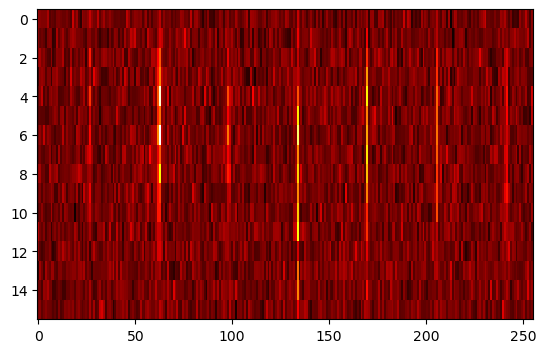

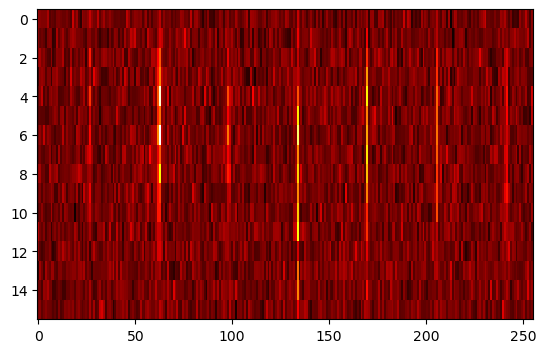

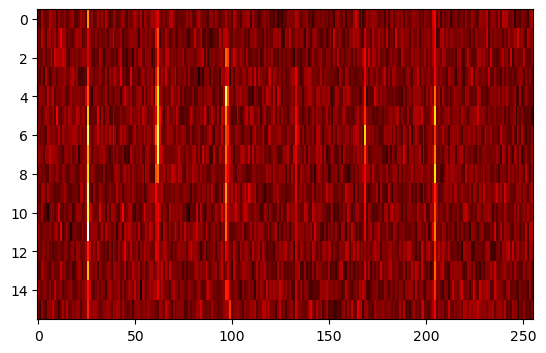

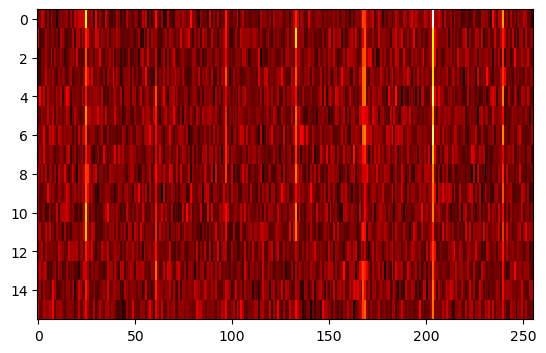

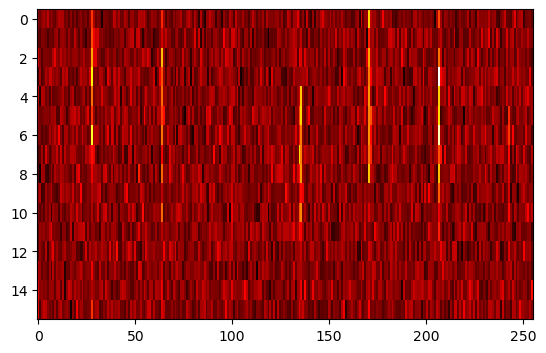

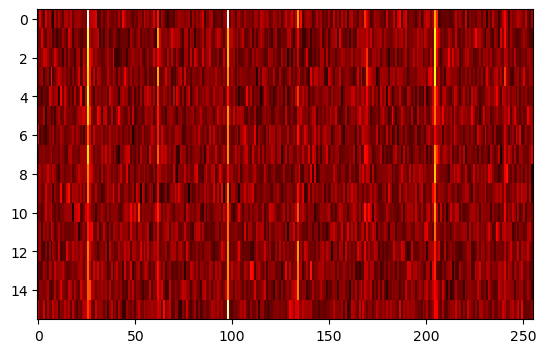

In [18]:
%matplotlib inline

plt.figure()
plt.imshow(normalize_data(target1_data)[0,:,:,0], cmap='hot', interpolation='nearest', aspect=10)

for i in range(5):
    plt.figure()
    plt.imshow(preprocessed_data[best_index[i],:, :], cmap='hot', interpolation='nearest', aspect=10)

### get some header information

In [19]:
header = Waterfall("../../../../../../../"+target1_converted, 
                 load_data = False).header
end = header['fch1']
foff = header['foff']
nchan = header['nchans']
start = end+nchan*foff
print(start, end)
intervals = (end-start)/ preprocessed_data.shape[0]
print(intervals)
print( target1["start"])

1797.94921875 2802.83203125
0.0007152557373046875
1961.2728595733643


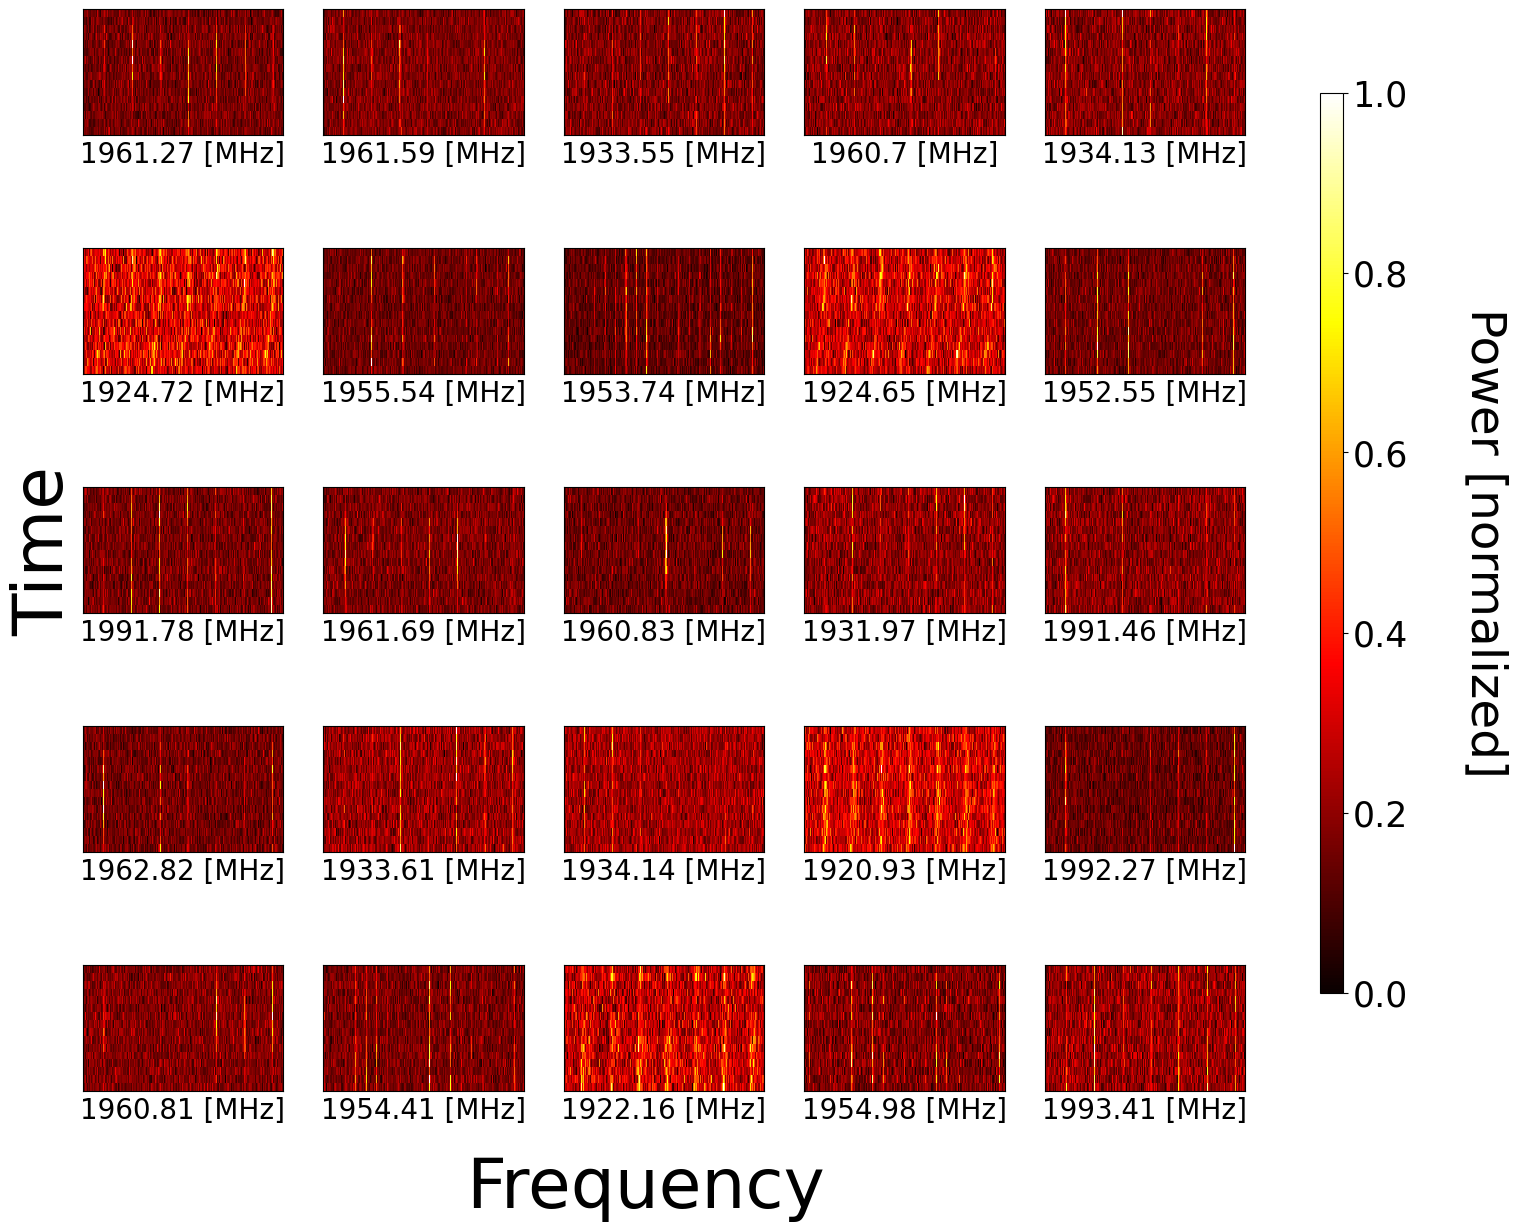

In [20]:
font_size = 25
plt.rcParams.update({'font.size': font_size})
f, ax = plt.subplots(nrows=5, ncols=5, figsize=(15,15))

count = 0
row_count = 0
for row in ax:
    col_count = 0 
    for col in row:
        im = col.imshow(preprocessed_data[best_index[count],:, :], cmap='hot', interpolation='nearest', aspect=10)
        freq = end-best_index[count]*intervals
        col.set_xlabel(str(round(freq, 2))+" [MHz]",  fontsize=font_size-5)  
        col.get_xaxis().set_ticks([])
        col.get_yaxis().set_ticks([])
        if col_count ==0 and row_count == 2:
            col.set_ylabel("Time",  fontsize=font_size*2)  
        col_count+=1
        count += 1 
    row_count += 1
    
f.text(0.5, 0.07, 'Frequency', ha='center', va='center', rotation=0, 
       fontsize=font_size*2)

cbaxes = f.add_axes([0.95, 0.2, 0.015, 0.6]) 
cbar = f.colorbar(im, cax=cbaxes)
cbar.ax.tick_params(labelsize=font_size)
f.text(1.06, 0.5, 'Power [normalized]', ha='center', va='center', rotation=270, 
       fontsize=font_size+10)

plt.show()

# Check Distribution

In [21]:
1176584*intervals+end

3644.3904876708984

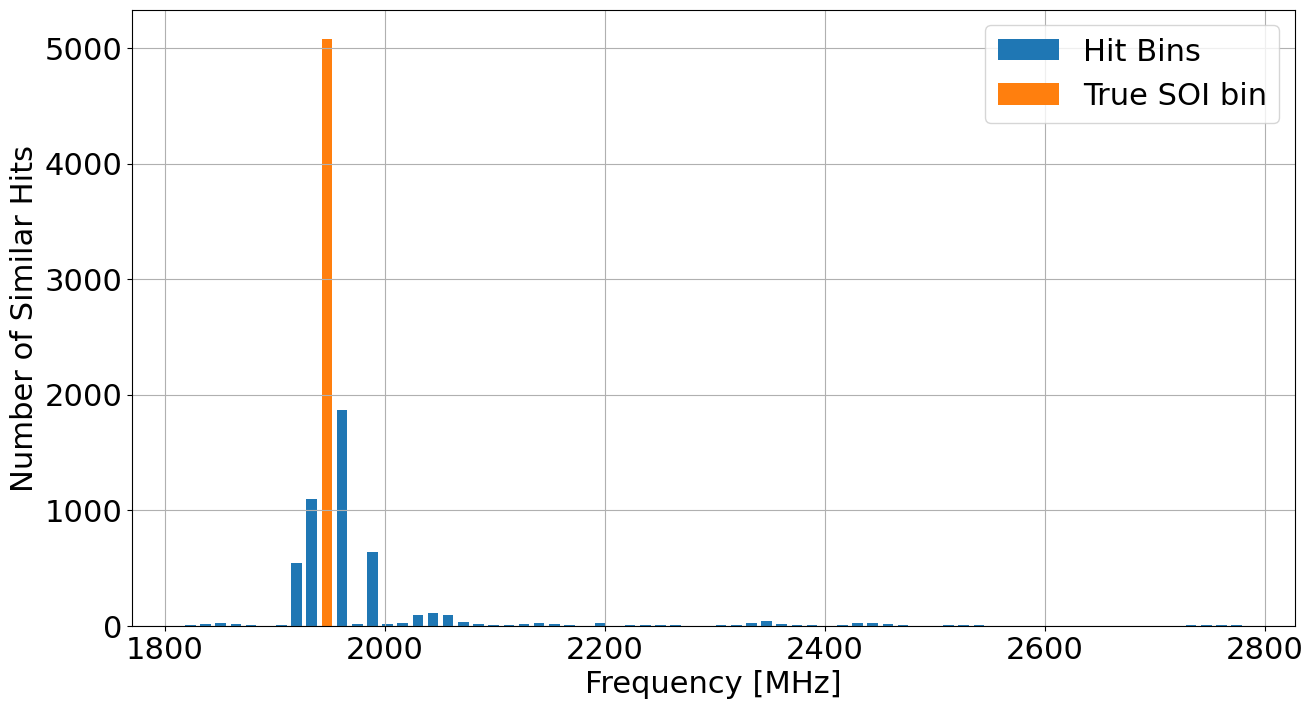

In [22]:
plt.rcParams.update({'font.size': 22})
plt.figure(figsize=(15,8))
hist, bins = np.histogram(end-best_index[:10_000]*intervals, bins=70)
width = 0.7 * (bins[1] - bins[0])
center = (bins[:-1] + bins[1:]) / 2
plt.bar(center, hist, align='center', width=width, label="Hit Bins")
key = 0
for i in range(len(center)):
    if center[i] > target1["start"]:
        key = i
        break
plt.bar(center[key-1], hist[key-1], align='center', width=width, label="True SOI bin")
plt.ylabel("Number of Similar Hits")
plt.xlabel("Frequency [MHz]")
plt.grid()
plt.legend()

# Merge Plots Together

100%|███████████████████████████████████████████| 1/1 [00:00<00:00, 1924.88it/s]


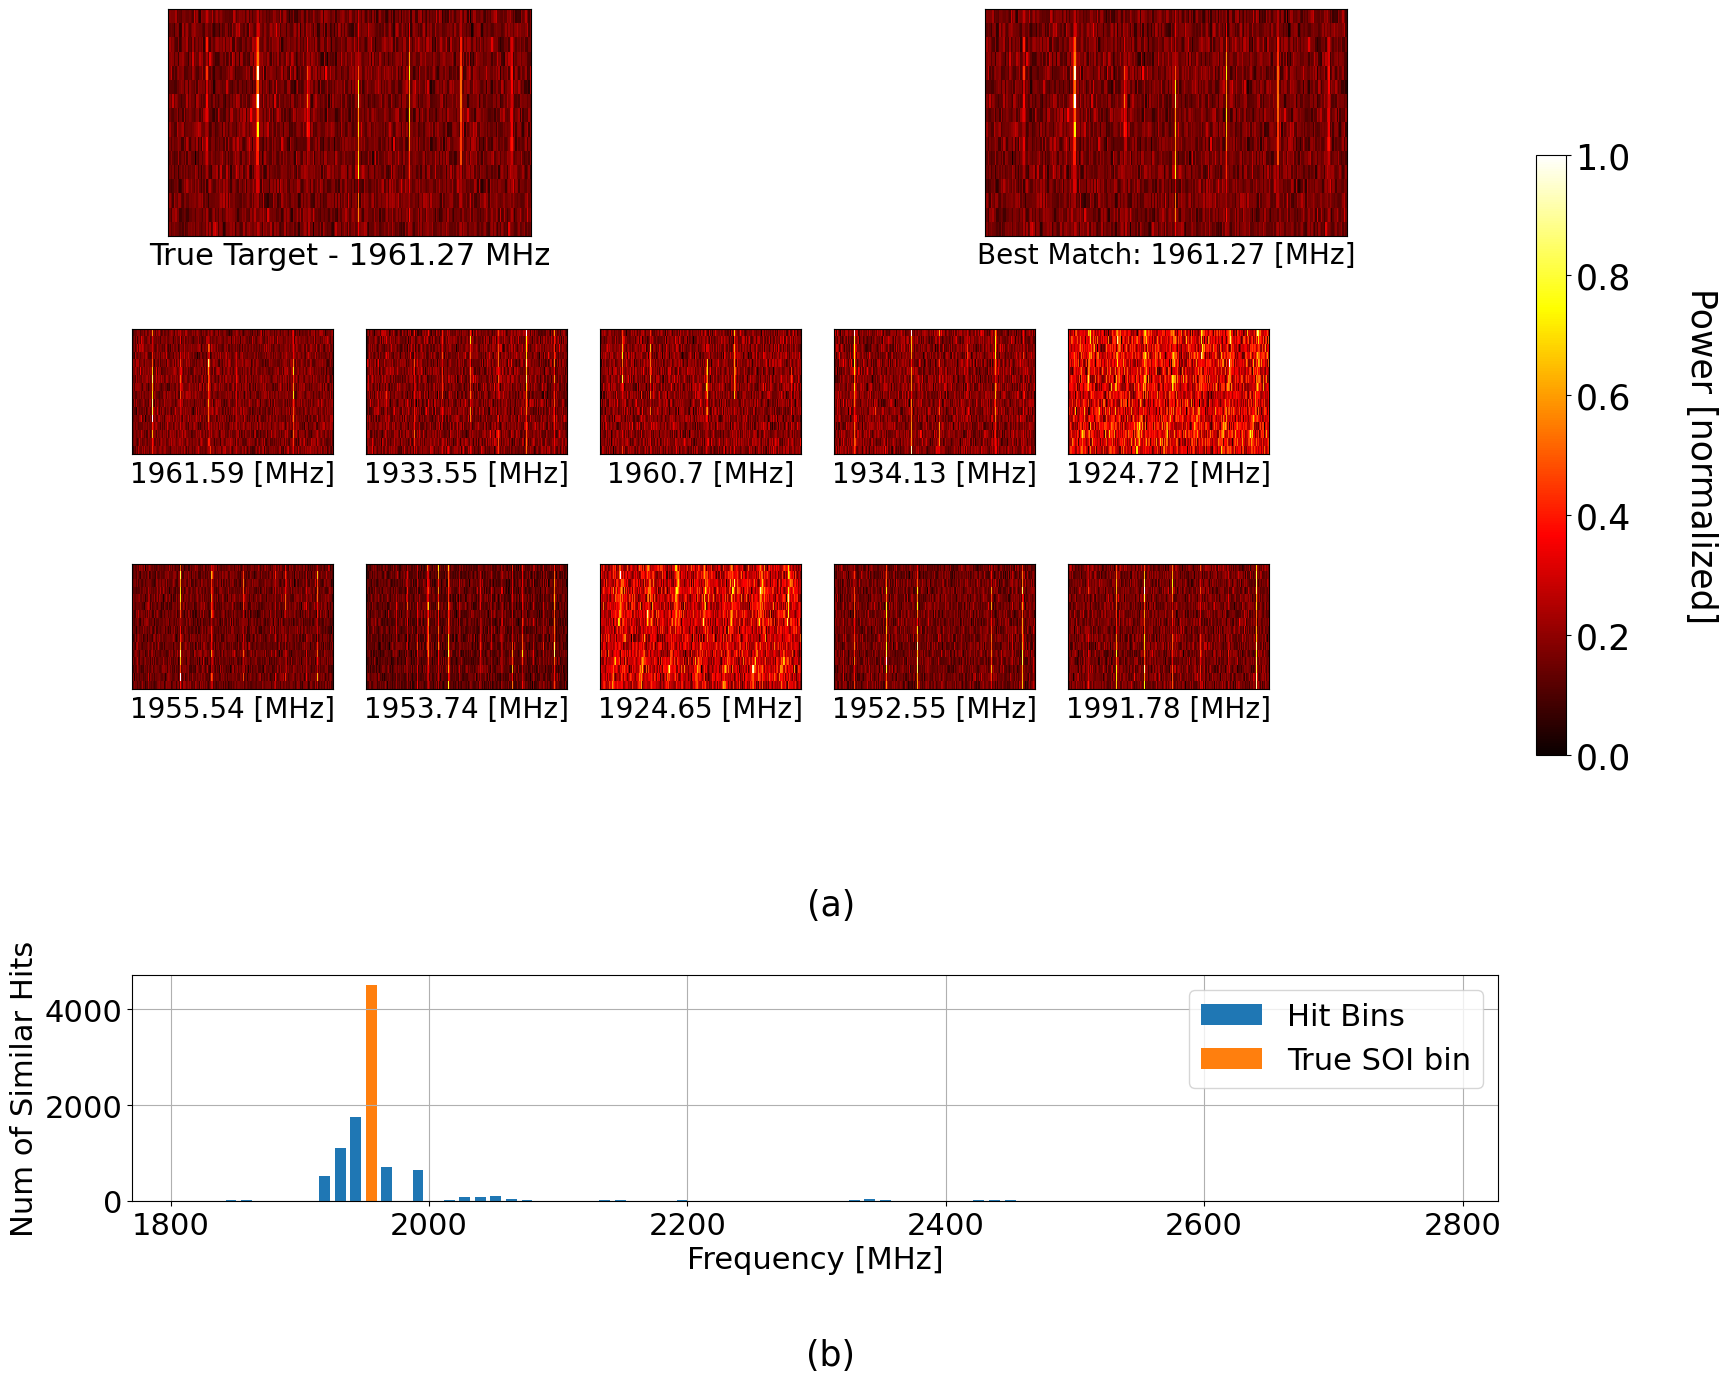

In [23]:
fig = plt.figure(figsize=(15, 15), layout="constrained")
spec = fig.add_gridspec(6, 6)

main = fig.add_subplot(spec[0, 0:2])
im = main.imshow(normalize_data(target1_data)[0,:,:,0], cmap='hot', interpolation='nearest', aspect=10)
main.get_xaxis().set_ticks([])
main.get_yaxis().set_ticks([])
main.set_xlabel("True Target - "+str(round(target1["start"], 2))+" MHz")

ax0 = fig.add_subplot(spec[0, 3:])
im = ax0.imshow(preprocessed_data[best_index[0],:, :], cmap='hot', interpolation='nearest', aspect=10)
ax0.get_xaxis().set_ticks([])
ax0.get_yaxis().set_ticks([])
freq = end-best_index[0]*intervals
ax0.set_xlabel("Best Match: "+str(round(freq, 2))+" [MHz]",  fontsize=font_size-5)          
count = 1
for i in range(1,3):
    for j in range(5):
        ax = fig.add_subplot(spec[i, j])
        im = ax.imshow(preprocessed_data[best_index[count],:, :], cmap='hot', interpolation='nearest', aspect=10)
        freq = end-best_index[count]*intervals
        ax.get_xaxis().set_ticks([])
        ax.get_yaxis().set_ticks([])
        ax.set_xlabel(str(round(freq, 2))+" [MHz]",  fontsize=font_size-5)  
        count +=1

fig.text(0.55, 0.40, '(a)', ha='center', va='center', rotation=0, fontsize=font_size)
# histogram
ax1 = fig.add_subplot(spec[4:5, :])  
hist, bins = np.histogram(end-best_index[:10000]*intervals, bins=80)
width = 0.7 * (bins[1] - bins[0])
center = (bins[:-1] + bins[1:]) / 2
plt.bar(center, hist, align='center', width=width, label="Hit Bins")
key = 0
for i in range(len(center)):
    if center[i] > target1["start"]:
        key = i
        break
ax1.bar(center[key-1], hist[key-1], align='center', width=width, label="True SOI bin")
ax1.legend()        
ax1.grid()     
ax1.set_xlabel("Frequency [MHz]")
ax1.set_ylabel("Num of Similar Hits")

# ax2 = fig.add_subplot(spec[4:, :])  

cbaxes = fig.add_axes([1.02, 0.5, 0.02, 0.4]) 
cbar = fig.colorbar(im, cax=cbaxes)
cbar.ax.tick_params(labelsize=font_size)
fig.text(1.13, 0.70, 'Power [normalized]', ha='center', va='center', rotation=270, 
       fontsize=font_size)

fig.text(0.55, 0.1, '(b)', ha='center', va='center', rotation=0, 
       fontsize=font_size)


target_name = target1['directory'].split("/")[-1].split('.')[0]
plt.savefig("bvae-plots/full_algo-"+target_name+".pdf", format="pdf")
